# Graph Networts

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import tensorflow as tf

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import uproot3 as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mfong/git/LCStudies/'
plotpath = path_prefix + 'classifier/Plots/'
modelpath = path_prefix + 'classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/atlas_mpl_style/__init__.py:163: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  _warn.warn(


In [3]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
sys.path
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu

/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/atlas_mpl_style/__init__.py:163: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  _warn.warn(


In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=24220)]) #in MB

print("Num GPUs Available: ", len(gpus))
tf.config.list_physical_devices()


Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# import pi+- vs. pi0 images

inputpath = '/clusterfs/ml4hep/mfong/ML4Pions/v7/'    # ml4hep1 machine
# inputpath = "/data0/mfong/v7/"    # voltan machine
#path = '/eos/user/m/mswiatlo/images/'
branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'cluster_cellE_norm']
rootfiles = ["pi0", "piplus", "piminus"]
trees = {
    rfile : ur.open(inputpath+rfile+".root")['ClusterTree']
    for rfile in rootfiles
}
pdata = {
    ifile : itree.pandas.df(branches, flatten=False)
    for ifile, itree in trees.items()
}

np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [7]:
cell_shapes = {
    'EMB1': (128,4),
    'EMB2': (16,16),
    'EMB3': (8,16),
    'TileBar0': (4,4),
    'TileBar1': (4,4),
    'TileBar2': (2,4),
}

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer)
        for layer in layers
    }
    for ifile, itree in trees.items()
}

In [8]:
pdata["pi0"].columns

Index(['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi',
       'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt',
       'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE',
       'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T',
       'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY',
       'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT',
       'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min',
       'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max',
       'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max',
       'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi',
       'cluster_cell_centerCellLayer', 'cluster_cellE_norm'],
      dtype='object')

In [65]:
n_cells = 0
for key in pcells["pi0"]:
    print(pcells["pi0"][key].shape)
    n_cells += pcells["pi0"][key].shape[1]
print("Total number of cells: " + str(n_cells))

(263891, 512)
(263891, 256)
(263891, 128)
(263891, 16)
(263891, 16)
(263891, 8)
Total number of cells: 936


## Create DataFrame

In [10]:
# df for pi0 only
df_p0 = pd.DataFrame(np.concatenate([pcells["pi0"][key] for key in pcells["pi0"].keys()], axis = 1))

col_names = []
for key in pcells["pi0"].keys():
    col_names.extend([key + "_" + str(i) for i in range(len(pcells["pi0"][key][0]))])
df_p0.columns = col_names

df_p0["is_p0"] = 1


# print(df_p0.shape)
# df_p0.head()

In [11]:
# df for pipplus and piminus
df_pp = pd.DataFrame(np.concatenate([pcells["piplus"][key] for key in pcells["piplus"].keys()], axis = 1))
df_pp.columns = col_names
df_pp["is_p0"] = 0

df_pm = pd.DataFrame(np.concatenate([pcells["piminus"][key] for key in pcells["piminus"].keys()], axis = 1))
df_pm.columns = col_names
df_pm["is_p0"] = 0

# print(df_pp.shape)
# df_pp.head()

In [12]:
# create final df
df = df_p0.append(df_pp.append(df_pm))
df = df.sample(frac=1) # Shuffle the df so pi0 are not all first
df.reset_index(inplace = True, drop = True)
df.head()

,EMB1_0,EMB1_1,EMB1_2,EMB1_3,EMB1_4,EMB1_5,EMB1_6,EMB1_7,EMB1_8,EMB1_9,EMB1_10,EMB1_11,EMB1_12,EMB1_13,EMB1_14,EMB1_15,EMB1_16,EMB1_17,EMB1_18,EMB1_19,EMB1_20,EMB1_21,EMB1_22,EMB1_23,EMB1_24,EMB1_25,EMB1_26,EMB1_27,EMB1_28,EMB1_29,EMB1_30,EMB1_31,EMB1_32,EMB1_33,EMB1_34,EMB1_35,EMB1_36,EMB1_37,EMB1_38,EMB1_39,EMB1_40,EMB1_41,EMB1_42,EMB1_43,EMB1_44,EMB1_45,EMB1_46,EMB1_47,EMB1_48,EMB1_49,...,EMB3_119,EMB3_120,EMB3_121,EMB3_122,EMB3_123,EMB3_124,EMB3_125,EMB3_126,EMB3_127,TileBar0_0,TileBar0_1,TileBar0_2,TileBar0_3,TileBar0_4,TileBar0_5,TileBar0_6,TileBar0_7,TileBar0_8,TileBar0_9,TileBar0_10,TileBar0_11,TileBar0_12,TileBar0_13,TileBar0_14,TileBar0_15,TileBar1_0,TileBar1_1,TileBar1_2,TileBar1_3,TileBar1_4,TileBar1_5,TileBar1_6,TileBar1_7,TileBar1_8,TileBar1_9,TileBar1_10,TileBar1_11,TileBar1_12,TileBar1_13,TileBar1_14,TileBar1_15,TileBar2_0,TileBar2_1,TileBar2_2,TileBar2_3,TileBar2_4,TileBar2_5,TileBar2_6,TileBar2_7,is_p0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000009,0.000038,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.000224,0.000315,0.001344,0.000428,0.002322,0.012944,0.014262,0.002498,0.001551,0.070766,0.140632,0.001669,0.003287,0.004747,0.008165,0.000888,0.000054,0.000776,0.001186,0.000146,0.000375,0.006990,0.007225,0.003866,0.001419,0.035971,0.047344,0.003773,0.000361,0.006787,0.003358,0.002189,0.0,0.000625,0.000405,0.000031,0.000024,0.001023,0.001606,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.011872,0.005269,0.000000,0.000000,0.628931,0.088836,0.002091,0.000000,0.030488,0.019321,0.004342,0.000000,0.000000,0.000177,0.001947,0.000000,0.019718,0.003629,0.000000,0.000000,0.087662,0.022248,0.000901,0.000000,0.006445,0.000219,0.000237,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1


## Create Graphs

In [13]:
# permutations for doubly connected edges
from itertools import permutations
import functools
import networkx as nx
import sonnet as snt

from graph_nets import blocks

from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf

In [14]:
event0 = df.loc[0]
event0

EMB1_0        0.000000
EMB1_1        0.000000
EMB1_2        0.000000
EMB1_3        0.000000
EMB1_4        0.000000
                ...   
TileBar2_4    0.000024
TileBar2_5    0.001023
TileBar2_6    0.001606
TileBar2_7    0.000000
is_p0         0.000000
Name: 0, Length: 937, dtype: float64

In [15]:
def make_fully_connected_edges(nodes):
    """
    returns a list of tuples with (sender_node, reciever_node) for a fully connected graph
    ex: [(1,2), (2,1), (0,1)]
    """
    n_nodes = len(nodes)
    return list(permutations(range(n_nodes), 2))

In [61]:
def make_graph(event):
    
    n_nodes = 0
    nodes = []
    MIN_VALUE = 0.07
    solution = "is_p0"
    
    nodes = [[cell] for cell in event[col_names][event[col_names] > MIN_VALUE]]
    n_nodes = len(nodes)
    if n_nodes < 1:
        return (None, None)
    nodes = np.array(nodes, dtype=np.float32)
    
    edge_endpoints = make_fully_connected_edges(nodes)
    senders = np.array([x[0] for x in edge_endpoints])
    receivers = np.array([x[1] for x in edge_endpoints])
    n_edges = len(edge_endpoints)
    edges = np.expand_dims(np.array([0.0]*n_edges, dtype=np.float32), axis=1)

    
    # TODO distance between cells as edge feature
    
    input_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([n_nodes], dtype=np.float32)
    }
    target_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([event[solution]], dtype=np.float32)
    }
    input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])
    target_graph = utils_tf.data_dicts_to_graphs_tuple([target_datadict])
    
    return (input_graph, target_graph)

In [62]:
def print_graphs_tuple(g, data=True):
    for field_name in graphs.ALL_FIELDS:
        per_replica_sample = getattr(g, field_name)
        if per_replica_sample is None:
            print(field_name, "EMPTY")
        else:
            print(field_name, "has shape", per_replica_sample.shape)
            if data and  field_name != "edges":
                print(per_replica_sample)

In [63]:
graphs_tuple0_input, graphs_tuple0_target = make_graph(event0)

print_graphs_tuple(graphs_tuple0_input, data=False)

nodes has shape (4, 1)
edges has shape (12, 1)
receivers has shape (12,)
senders has shape (12,)
globals has shape (1, 1)
n_node has shape (1,)
n_edge has shape (1,)


In [34]:
graphs = []
for i in range(100):
    graphs.append(make_graph(df.loc[i]))

In [35]:
# check how many edges some graphs have
for test_input, _ in graphs:
    if test_input is not None:
        print(test_input.n_edge)

tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([20], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([0], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([0], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([20], shape=(1,), dtype=int32)
tf.Tensor([0], shape=(1,), dtype=int32)
tf.Tensor([20], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([12], shape=(1,), dtype=int32)
tf.Tensor([20], shape=(1,), dtype=int32)
tf.Tensor([6], shape=(1,), 

In [36]:
# plotting functions from example (broken)

# def plot_graph_networkx(graph, ax, pos=None):
#   node_labels = {node: "{:.3g}".format(data["features"][0])
#                  for node, data in graph.nodes(data=True)
#                  if data["features"] is not None}
#   edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
#                  for sender, receiver, data in graph.edges(data=True)
#                  if data["features"] is not None}
#   global_label = ("{:.3g}".format(graph.graph["features"][0])
#                   if graph.graph["features"] is not None else None)

#   if pos is None:
#     pos = nx.spring_layout(graph)
#   nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

#   if edge_labels:
#     nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

#   if global_label:
#     plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

#   ax.yaxis.set_visible(False)
#   ax.xaxis.set_visible(False)
#   return pos

# def plot_graphs_tuple(graphs_tuple):
#   networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
#   num_graphs = len(networkx_graphs)
#   _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
#   if num_graphs == 1:
#     axes = axes,
#   for graph, ax in zip(networkx_graphs, axes):
#     plot_graph_networkx(graph, ax)

# plot_graphs_tuple(graphs_tuple0_input)

## Graph net

In [21]:
# Need the newest dev version of graph_nets (see https://github.com/deepmind/graph_nets/issues/139)
# as of 3/25/2021


# !pip install git+git://github.com/deepmind/graph_nets.git

In [23]:
NUM_LAYERS = 2
def make_mlp_model():
  """Instantiates a new MLP, followed by LayerNorm.

  The parameters of each new MLP are not shared with others generated by
  this function.

  Returns:
    A Sonnet module which contains the MLP and LayerNorm.
  """
  # the activation function choices:
  # swish, relu, relu6, leaky_relu
  return snt.Sequential([
#       snt.nets.MLP([128, 64]*NUM_LAYERS,
    snt.nets.MLP([32, 64, 128, 64],
                    activation=tf.nn.relu,
                    activate_final=True, 
                  #  dropout_rate=DROPOUT_RATE
        ),
      snt.LayerNorm(axis=-1, create_scale=True, create_offset=False)
  ])

In [24]:
class MLPGraphNetwork(snt.Module):
    """GraphIndependent with MLP edge, node, and global models."""
    def __init__(self, name="MLPGraphNetwork"):
        super(MLPGraphNetwork, self).__init__(name=name)
        self._network = modules.GraphNetwork(
            edge_model_fn=make_mlp_model,
            node_model_fn=make_mlp_model,
            global_model_fn=make_mlp_model
            )

    def __call__(self, inputs,
            edge_model_kwargs=None,
            node_model_kwargs=None,
            global_model_kwargs=None):
        return self._network(inputs,
                      edge_model_kwargs=edge_model_kwargs,
                      node_model_kwargs=node_model_kwargs,
                      global_model_kwargs=global_model_kwargs)

In [26]:
LATENT_SIZE = 128
NUM_LAYERS = 3

class GlobalClassifierNoEdgeInfo(snt.Module):

    def __init__(self, name="GlobalClassifierNoEdgeInfo"):
        super(GlobalClassifierNoEdgeInfo, self).__init__(name=name)

        self._edge_block = blocks.EdgeBlock(
            edge_model_fn=make_mlp_model,
            use_edges=False,              # all edge features are 0.0 right now, use false for now
            use_receiver_nodes=True,
            use_sender_nodes=True,
            use_globals=False,            # can try true later
            name='edge_encoder_block')

        self._node_encoder_block = blocks.NodeBlock(
            node_model_fn=make_mlp_model,
            use_received_edges=False,      # if assigning edge features set to true
            use_sent_edges=False,          # if assigning edge features set to true
            use_nodes=True,
            use_globals=False,             # can try true later to see if any effect
            name='node_encoder_block'
        )

        self._global_block = blocks.GlobalBlock(
            global_model_fn=make_mlp_model,
            use_edges=True,
            use_nodes=True,
            use_globals=True,
        )

        self._core = MLPGraphNetwork()
        # Transforms the outputs into appropriate shapes.
        global_output_size = 1
        global_fn = lambda: snt.Sequential([
#             snt.nets.MLP([32, 64],),
#             snt.nets.MLP([128, 64],),
            snt.nets.MLP([64, 128, 32, global_output_size], name='global_output'),       # TODO add more layers, end with size 1
            tf.sigmoid
        ])

        self._output_transform = modules.GraphIndependent(None, None, global_fn)

    def __call__(self, input_op, num_processing_steps):
        latent = self._global_block(self._edge_block(self._node_encoder_block(input_op)))
        latent0 = latent

        output_ops = []
        for _ in range(num_processing_steps):
            core_input = utils_tf.concat([latent0, latent], axis=1)
            latent = self._core(core_input)
            output_ops.append(self._output_transform(latent))

        return output_ops

In [27]:
model = GlobalClassifierNoEdgeInfo()

In [28]:
output_graphs = model(graphs_tuple0_input, 1)

In [29]:
[x.globals for x in output_graphs]

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49173295]], dtype=float32)>]

In [30]:
# Loss function:

class GlobalLoss:
    def __init__(self, real_global_weight, fake_global_weight):
        self.w_global_real = real_global_weight
        self.w_global_fake = fake_global_weight

    def __call__(self, target_op, output_ops):
        global_weights = target_op.globals * self.w_global_real \
            + (1 - target_op.globals) * self.w_global_fake
        
        print(global_weights)
        
        loss_ops = [
            tf.compat.v1.losses.log_loss(target_op.globals, output_op.globals, weights=global_weights)
            for output_op in output_ops
        ]
        return tf.stack(loss_ops)

In [31]:
loss_function_global = GlobalLoss(real_global_weight = 1.0, fake_global_weight = 1.0)

In [32]:
loss_function_global(graphs_tuple0_target, output_graphs)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.67674804], dtype=float32)>

In [47]:
input_list = []
target_list = []
counter = 0
index = 0
# while counter < 100:
#     input_graph, target_graph = train_graphs[index]
#     if input_graph is None:
#         index += 1
#         continue
#     target_list.append(target_graph)
#     input_list.append(input_graph)
#     counter += 1

# concated_inputs = utils_tf.concat(input_list, axis=0)
# concated_targets = utils_tf.concat(target_graph, axis=0)


for data in train_graphs[:1000]:
    input_tr, target_tr = data
    if input_tr is None:
            continue
    input_list.append(input_tr)
    target_list.append(target_tr)
    if len(input_list) >= batch_size:
        input_tr = utils_tf.concat(input_list, axis=0)
        target_tr = utils_tf.concat(target_list, axis=0)
        x = model(input_tr, 1)
        break


NameError: name 'train_graphs' is not defined

## Model Training

In [33]:
# TODO modify acc function

# def compute_accuracy(target, output):
#     """Calculate model accuracy.

#     Returns the number of correctly predicted links and the number
#     of completely solved list sorts (100% correct predictions).

#     Args:
#     target: A `graphs.GraphsTuple` that contains the target graph.
#     output: A `graphs.GraphsTuple` that contains the output graph.

#     Returns:
#     correct: A `float` fraction of correctly labeled nodes/edges.
#     solved: A `float` fraction of graphs that are completely correctly labeled.
#     """
#     tdds = utils_np.graphs_tuple_to_data_dicts(target)
#     odds = utils_np.graphs_tuple_to_data_dicts(output)
#     cs = []
#     ss = []
#     for td, od in zip(tdds, odds):
#         num_elements = td["nodes"].shape[0]
#         xn = np.argmax(td["nodes"], axis=-1)
#         yn = np.argmax(od["nodes"], axis=-1)

#         xe = np.reshape(
#             np.argmax(
#                 np.reshape(td["edges"], (num_elements, num_elements, 2)), axis=-1),
#             (-1,))
#         ye = np.reshape(
#             np.argmax(
#                 np.reshape(od["edges"], (num_elements, num_elements, 2)), axis=-1),
#             (-1,))
#         c = np.concatenate((xn == yn, xe == ye), axis=0)
#         s = np.all(c)
#         cs.append(c)
#         ss.append(s)
#     correct = np.mean(np.concatenate(cs, axis=0))
#     solved = np.mean(np.stack(ss))
#     return correct, solved

In [34]:
def get_signature(dataset, batch_size):
    """
    Get signature of inputs for the training loop.
    The signature is used by the tf.function
    """

    input_list = []
    target_list = []
    for _, data in dataset.iterrows():
        dd = make_graph(data)
        if dd[0] is not None:
            input_list.append(dd[0])
            target_list.append(dd[1])
            
        if len(input_list) == batch_size:
            break

    inputs = utils_tf.concat(input_list, axis=0)
    targets = utils_tf.concat(target_list, axis=0)
    input_signature = (
      utils_tf.specs_from_graphs_tuple(inputs),
      utils_tf.specs_from_graphs_tuple(targets)
    )
    
    return input_signature

In [35]:
batch_size = 50
input_signature = get_signature(df, batch_size)


# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 2
num_processing_steps_ge = 2


learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)


# model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
last_iteration = 0
generalization_iteration = 0

logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []


@functools.partial(tf.function, input_signature=input_signature)
def update_step(inputs_tr, targets_tr):
    print("Tracing update_step")
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, num_processing_steps_tr)
        loss_ops_tr = loss_function_global(targets_tr, outputs_tr)
        loss_op_tr = tf.math.reduce_sum(loss_ops_tr) / tf.constant(num_processing_steps_tr, dtype=tf.float32)

    gradients = tape.gradient(loss_op_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_op_tr

In [36]:
from sklearn.model_selection import train_test_split

# train and generalization df
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

In [37]:
# normalize values to gaussian
from sklearn.preprocessing import StandardScaler

# fit scaler to train set
scaler = StandardScaler()
scaler.fit(df_train.drop("is_p0", axis=1))

# scale the train set
df_train_scaled = pd.DataFrame(scaler.transform(df_train.drop("is_p0", axis=1)))
df_train_scaled["is_p0"] = df_train["is_p0"].values
df_train_scaled.columns = df_train.columns

# scale the test set
df_test_scaled = pd.DataFrame(scaler.transform(df_test.drop("is_p0", axis=1)))
df_test_scaled["is_p0"] = df_test["is_p0"].values
df_test_scaled.columns = df_test.columns

In [ ]:
%%capture output
%%time
# TODO this is very slow (1.5 hours for full 1100000 row dataset)
# 5 min for 50000 rows
# make graphs for each event
train_graphs = [make_graph(event) for _, event in df_train_scaled.iterrows()]
test_graphs = [make_graph(event) for _, event in df_test_scaled.iterrows()]

In [120]:
train_graphs[0]

(GraphsTuple(nodes=<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[0.48329577],
        [3.3163548 ],
        [0.751511  ],
        [4.6038504 ]], dtype=float32)>, edges=<tf.Tensor: shape=(12, 1), dtype=float32, numpy=
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32)>, receivers=<tf.Tensor: shape=(12,), dtype=int32, numpy=array([1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2], dtype=int32)>, senders=<tf.Tensor: shape=(12,), dtype=int32, numpy=array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3], dtype=int32)>, globals=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.]], dtype=float32)>, n_node=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([4], dtype=int32)>, n_edge=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([12], dtype=int32)>),
 GraphsTuple(nodes=<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[0.48329577],
        [3.3163548 ],
        [0.

In [ ]:
"""
save train_graphs and test_graphs objects to file, it takes too long to make
"""
import pickle

def save_object(obj, filename):
    with open(filename, "wb") as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# save_object(train_graphs, "Temp/train_graphs_scaled.pkl")
# save_object(train_graphs, "Temp/test_graphs_scaled.pkl")

"""
Load the graph dataset from pickle object files
"""
# file = open("Temp/train_graphs.pkl",'rb')
# train_graphs = pickle.load(file)
# file.close()

# file = open("Temp/test_graphs.pkl",'rb')
# test_graphs = pickle.load(file)
# file.close()


In [122]:
def loop_dataset(datasets, batch_size):
    if batch_size > 0:
        in_list = []
        target_list = []
        for dataset in datasets:
            inputs_tr, targets_tr = dataset
            if inputs_tr is None:
                continue
            in_list.append(inputs_tr)
            target_list.append(targets_tr)
            if len(in_list) == batch_size:
                inputs_tr = utils_tf.concat(in_list, axis=0)
                targets_tr = utils_tf.concat(target_list, axis=0)
                yield (inputs_tr, targets_tr)
                in_list = []
                target_list = []
    else:
        for dataset in datasets:
            if dataset is None:
                continue
            yield dataset

In [123]:
# create generator that yields a graph of the batch_size concatenated graphs
training_data = loop_dataset(train_graphs, batch_size)

In [124]:
input_tr, target_tr = next(training_data)

In [125]:
len(train_graphs)

907588

In [122]:
# %%capture output
# %%time
# Data / training parameters.
num_training_iterations = 20


# for epoch in range(1000):
#     total_loss = 0.
#     num_batches = 0
    
#     for _ in range(num_training_iterations):
#         input_tr, target_tr = next(training_data)
#         total_loss += update_step(input_tr, target_tr)[1].numpy()
#         num_batches += 1
        
#     loss_tr = total_loss / num_batches
#     losses_tr.append(loss_tr)
#     print(f"Epoch: {epoch}\tLoss value: {loss_tr}")

current_loss_list = []
for epoch in range(5):
    total_loss = 0.
    num_batches = 0
    
    input_list = []
    target_list = []
    
    
    
    for data in train_graphs:
        input_tr, target_tr = data
        if input_tr is None:
                continue
        input_list.append(input_tr)
        target_list.append(target_tr)
        if len(input_list) >= batch_size:
            input_tr = utils_tf.concat(input_list, axis=0)
            target_tr = utils_tf.concat(target_list, axis=0)
            
            current_loss = update_step(input_tr, target_tr)[1].numpy()
            total_loss += current_loss
            
            if num_batches % 10 == 0:
                current_loss_list.append(current_loss)
            
            num_batches += 1
            input_list = []
            target_list = []
            
            # TODO add a checkpoint > save to disk
    
    loss_tr = total_loss / num_batches
    losses_tr.append(loss_tr)
    print(f"Epoch: {epoch}\tLoss value: {loss_tr}")

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[414940,64] and type bool on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/GlobalClassifierNoEdgeInfo/MLPGraphNetwork/graph_network/node_block/received_edges_to_nodes_aggregator/ones_like (defined at <ipython-input-35-a7f54c7ea6cd>:36) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Identity_10/_98]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[414940,64] and type bool on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/GlobalClassifierNoEdgeInfo/MLPGraphNetwork/graph_network/node_block/received_edges_to_nodes_aggregator/ones_like (defined at <ipython-input-35-a7f54c7ea6cd>:36) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_update_step_207394654]

Function call stack:
update_step -> update_step


In [114]:
output.show()

Tracing update_step
Tensor("add:0", shape=(50, 1), dtype=float32)
Tracing update_step
Tensor("add:0", shape=(50, 1), dtype=float32)


/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


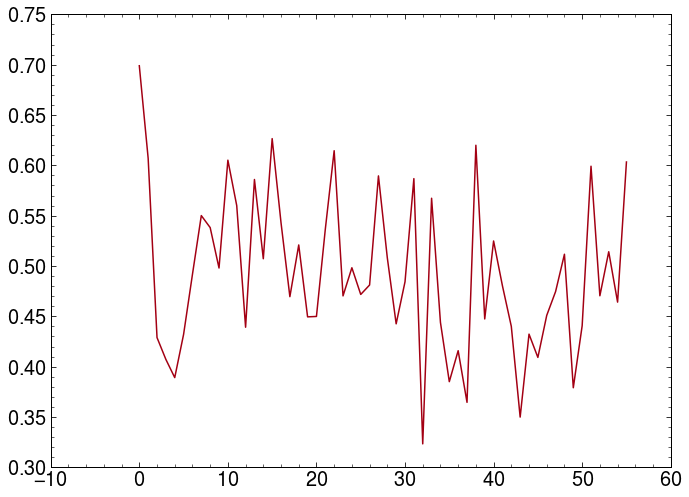

In [113]:
plt.plot(current_loss_list)

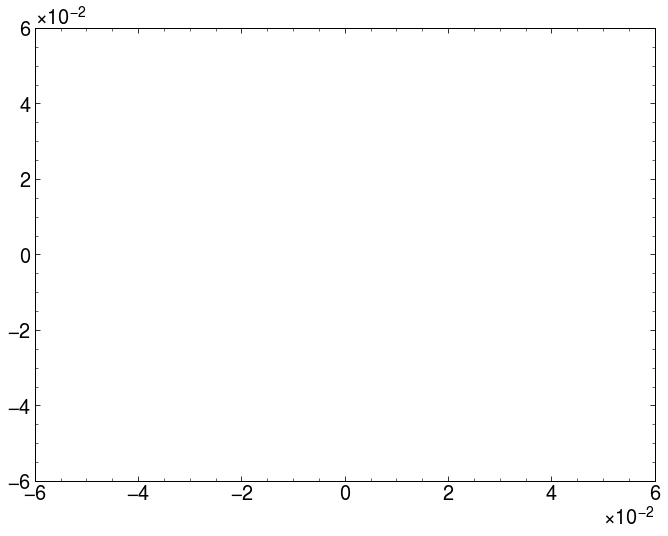

In [115]:
plt.plot(losses_tr)